##### imports 

In [76]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import differential_evolution   
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
import pandas as pd
import math 
from datetime import date
from scipy.integrate import solve_ivp
import sys
import os
import copy 
#!pip install lifelines
import seaborn as sns
import statistics
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from scipy import stats

##### data

In [3]:
# Reading data
df = pd.read_csv("Tumor_lengths.csv")
df = df.loc[~df['ID'].isin(['A1001','A1003', 'A1015', 'E1034'])] # remove patients with too few data points

##### functions 

In [4]:
# Gompertizian population model
def system_ode_gompertizian(days,populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #sensitivity to medication
    m=1
    epsilon = 1e-9
    log_arg = kmax/(Spop + Rpop + epsilon) # stop division by 0

    if log_arg <= 0:
        return [1e30, 1e30] # return large error if log is 0 or negative

    dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*m)*Spop 
    dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop
    return [dSpop_dt, dRpop_dt]

# Gompertizian cost function
def cost_func_gompertizian(params, days, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    epsilon = 1e-9
    
    pred_data = solve_ivp(system_ode_gompertizian, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data.y[0]
        rpop = pred_data.y[1]
        sum_pops = spop + rpop
        sumsq_error = np.sum((sum_pops-data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30

    return msq_error


##### fitting model

In [5]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    print("Working on patient:", id, " Number of data points:", len(days))

# fitting patient data to equations (r,Kmax,lamda,spop,rpop)
    max_value = max(data[0], data[-1])

    # these are pretty good - don't delete 
    bounds = [(1e-3, 2e-1), (1.1*max_value, 2*max_value), (1e-1, 10),(0, data[0]), (0, 3*data[0])]
    init_params = [1e-2, 1.2*max_value,3, data[0]-1e-3, 1e-3]

    #trying these
    bounds = [(1e-3, 2e-1), (1.1*max_value, 2*max_value), (1e-1, 10),(0, data[0]), (0, 3*data[0])]
    init_params = [1e-2, 1.2*max_value,3, data[0]-1e-3, 1e-3]

    opt_result_log = minimize(cost_func_gompertizian, init_params, 
                              args=(days, data), bounds = bounds, method="nelder-mead")
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun] 


Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


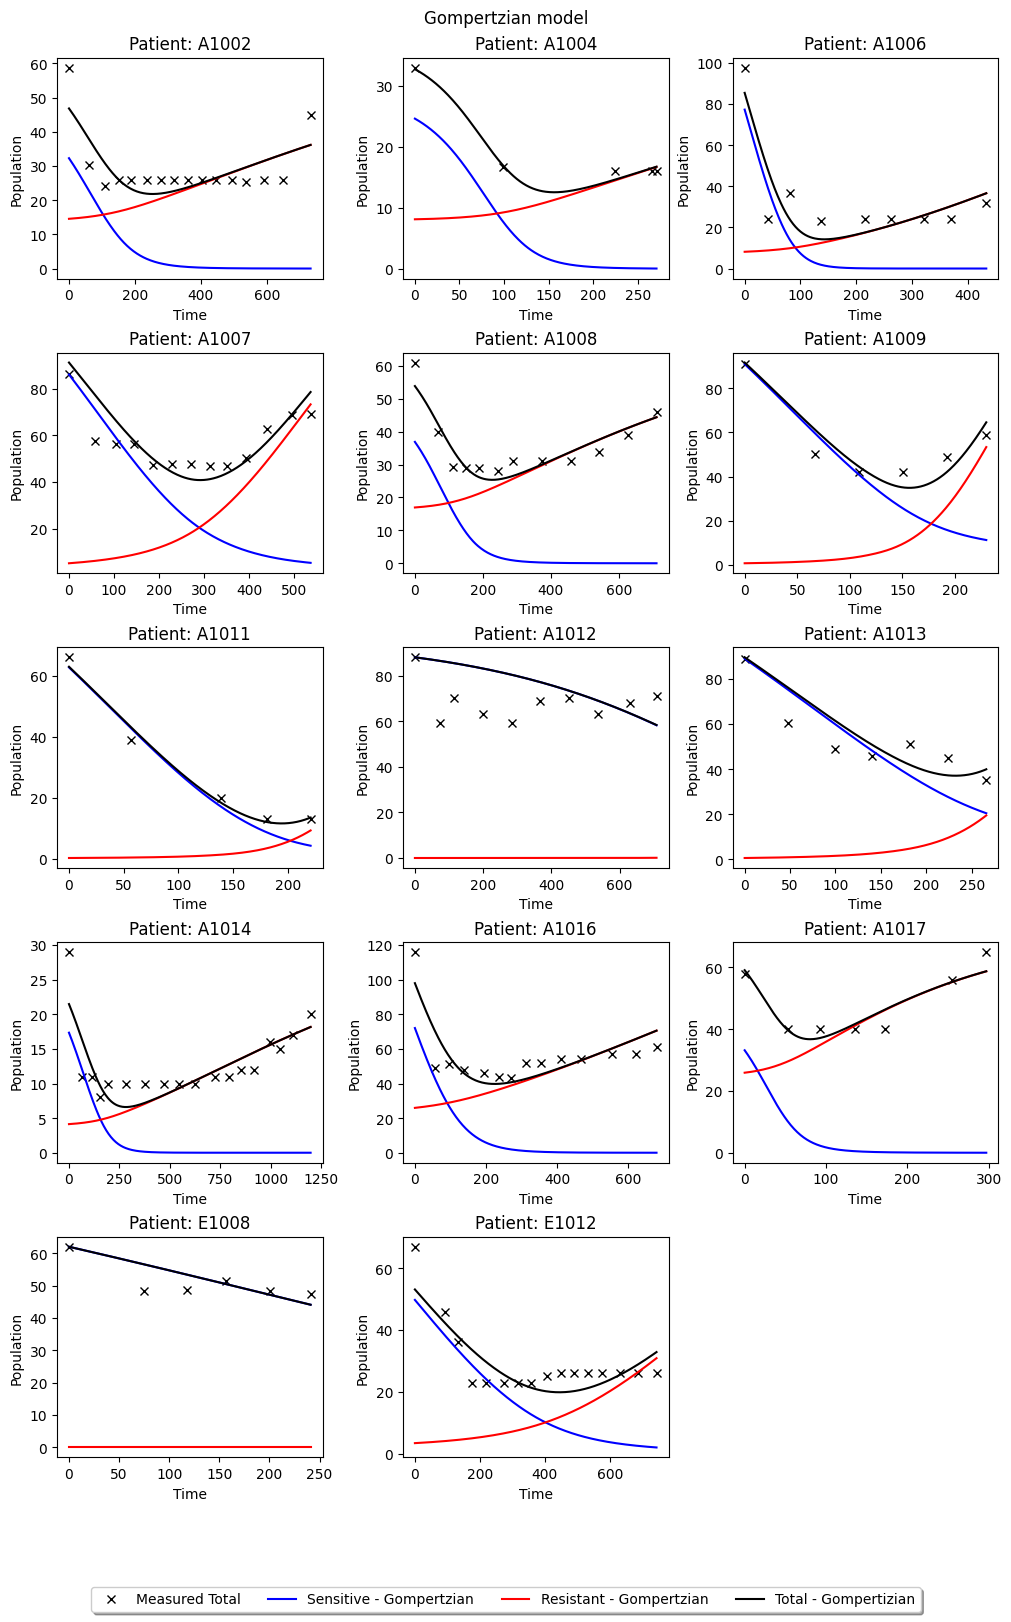

In [6]:
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_gom = master_dictionary[id]
    init_populations_gom = optimal_params_gom[3:-1]

    pred_data_gom = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_gom, dense_output=True,
                            args = tuple([optimal_params_gom[:3]]))
    sum_pops_gom = np.sum(pred_data_gom.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_gom.sol(tspan)[0], 'b-', label='Sensitive - Gompertz ')
    ax.plot(tspan, pred_data_gom.sol(tspan)[1], 'r-', label='Resistant - Gompertz') 
    ax.plot(tspan, sum_pops_gom, 'k-', label='Total - Gompertz')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Gompertzian'),
                   Line2D([0], [0], color='r', label='Resistant - Gompertzian'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Gompertizian'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model')  
plt.show()

In [7]:
df_gomp = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','lamda','spop_0','rpop_0','mse'])
df_gomp

,r,Kmax,lamda,spop_0,rpop_0,mse
A1002,0.001521,64.570000,10.000000,32.270030,14.549193,30.499897
A1004,0.003651,36.300000,9.999849,24.654014,8.123389,0.578391
A1006,0.001702,191.839419,9.885875,77.272520,8.148197,122.330237
A1007,0.004420,172.400000,2.041639,86.200000,5.122213,57.330244
A1008,0.002008,67.100000,10.000000,36.892883,16.960408,12.417544
A1009,0.015042,182.000000,1.480977,91.000000,0.686960,42.844703
A1011,0.010437,132.000000,1.705477,62.691120,0.204373,5.903949
A1012,0.025372,96.800000,1.093256,87.997560,0.001112,212.956841
A1013,0.010979,175.842616,1.425308,89.000000,0.614391,84.498770
A1014,0.001201,31.900000,10.000000,17.344367,4.133560,7.437065


##### Gompertzian with differential evolution for parameters

In [8]:
from scipy.optimize import differential_evolution
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    max_value = max(data[0], data[-1])

    print("Working on patient:", id, " Number of data points:", len(days))
    bounds = [(1e-3, 2e-1), (1.1*max_value, 2*max_value), (1e-1, 10),(0, data[0]), (0, 3*data[0])]

    # Use differential_evolution to perform a random search
    opt_result_log = differential_evolution(cost_func_gompertizian, bounds, args=(days, data))
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result_log.x.tolist() + [opt_result_log.fun]

Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5


C:\Users\lstocker\AppData\Local\Temp\ipykernel_13336\3376385897.py:32: RuntimeWarning: overflow encountered in square
  sumsq_error = np.sum((sum_pops-data)**2)


Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


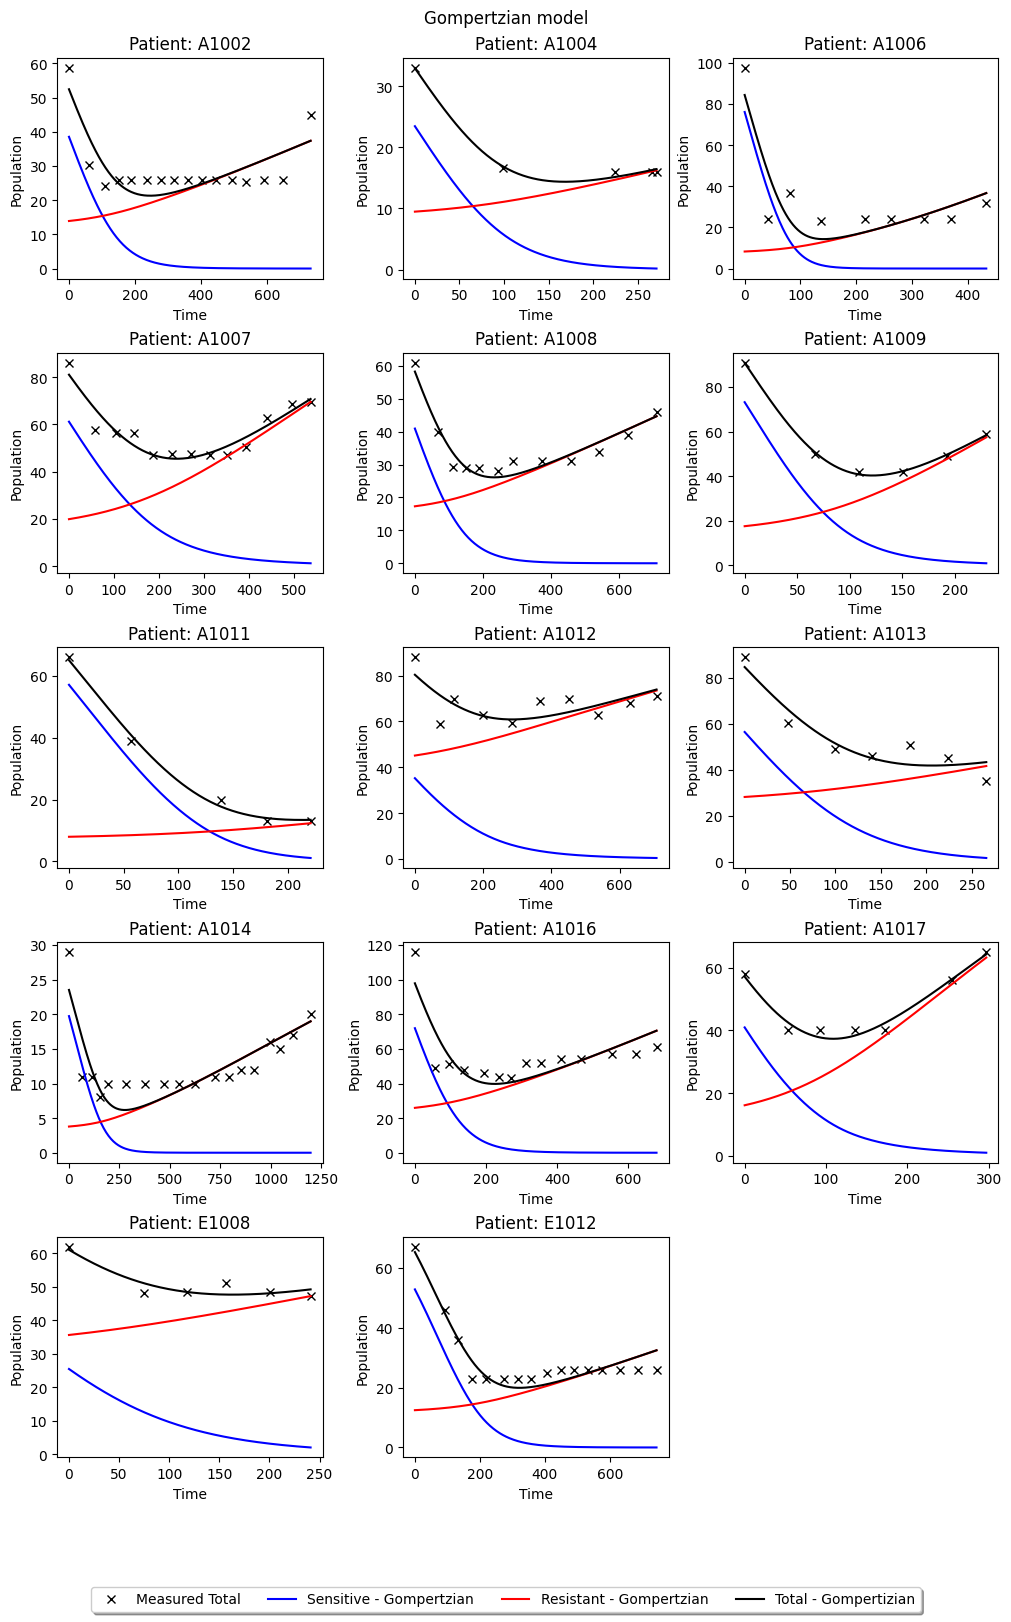

In [9]:
# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_gom = master_dictionary[id]
    init_populations_gom = optimal_params_gom[3:-1]

    pred_data_gom = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_gom, dense_output=True,
                            args = tuple([optimal_params_gom[:3]]))
    sum_pops_gom = np.sum(pred_data_gom.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_gom.sol(tspan)[0], 'b-', label='Sensitive - Gompertz ')
    ax.plot(tspan, pred_data_gom.sol(tspan)[1], 'r-', label='Resistant - Gompertz') 
    ax.plot(tspan, sum_pops_gom, 'k-', label='Total - Gompertz')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Gompertzian'),
                   Line2D([0], [0], color='r', label='Resistant - Gompertzian'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Gompertizian'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model')  
plt.show()

In [10]:
df_gomp = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','lamda','spop_0','rpop_0','mse'])
df_gomp

,r,Kmax,lamda,spop_0,rpop_0,mse
A1002,0.001000,109.587043,10.000000,38.524235,13.903955,24.550526
A1004,0.001511,65.998821,10.000000,23.451859,9.484617,0.208158
A1006,0.001675,194.750947,9.991093,76.116531,8.271814,120.547681
A1007,0.002062,172.214248,4.116798,61.159521,19.900273,15.025369
A1008,0.001046,121.867918,9.999623,40.936885,17.318382,6.217029
A1009,0.004068,181.991221,4.631374,73.221616,17.616102,0.503607
A1011,0.001201,131.999996,10.000000,57.100015,7.960202,2.082894
A1012,0.001000,132.272022,10.000000,35.245202,45.130216,33.649940
A1013,0.001173,177.960957,9.991165,56.501991,28.246781,30.306809
A1014,0.001000,42.983292,10.000000,19.737825,3.783313,6.408376


##### Gompertzian DE with 1/2 dose 

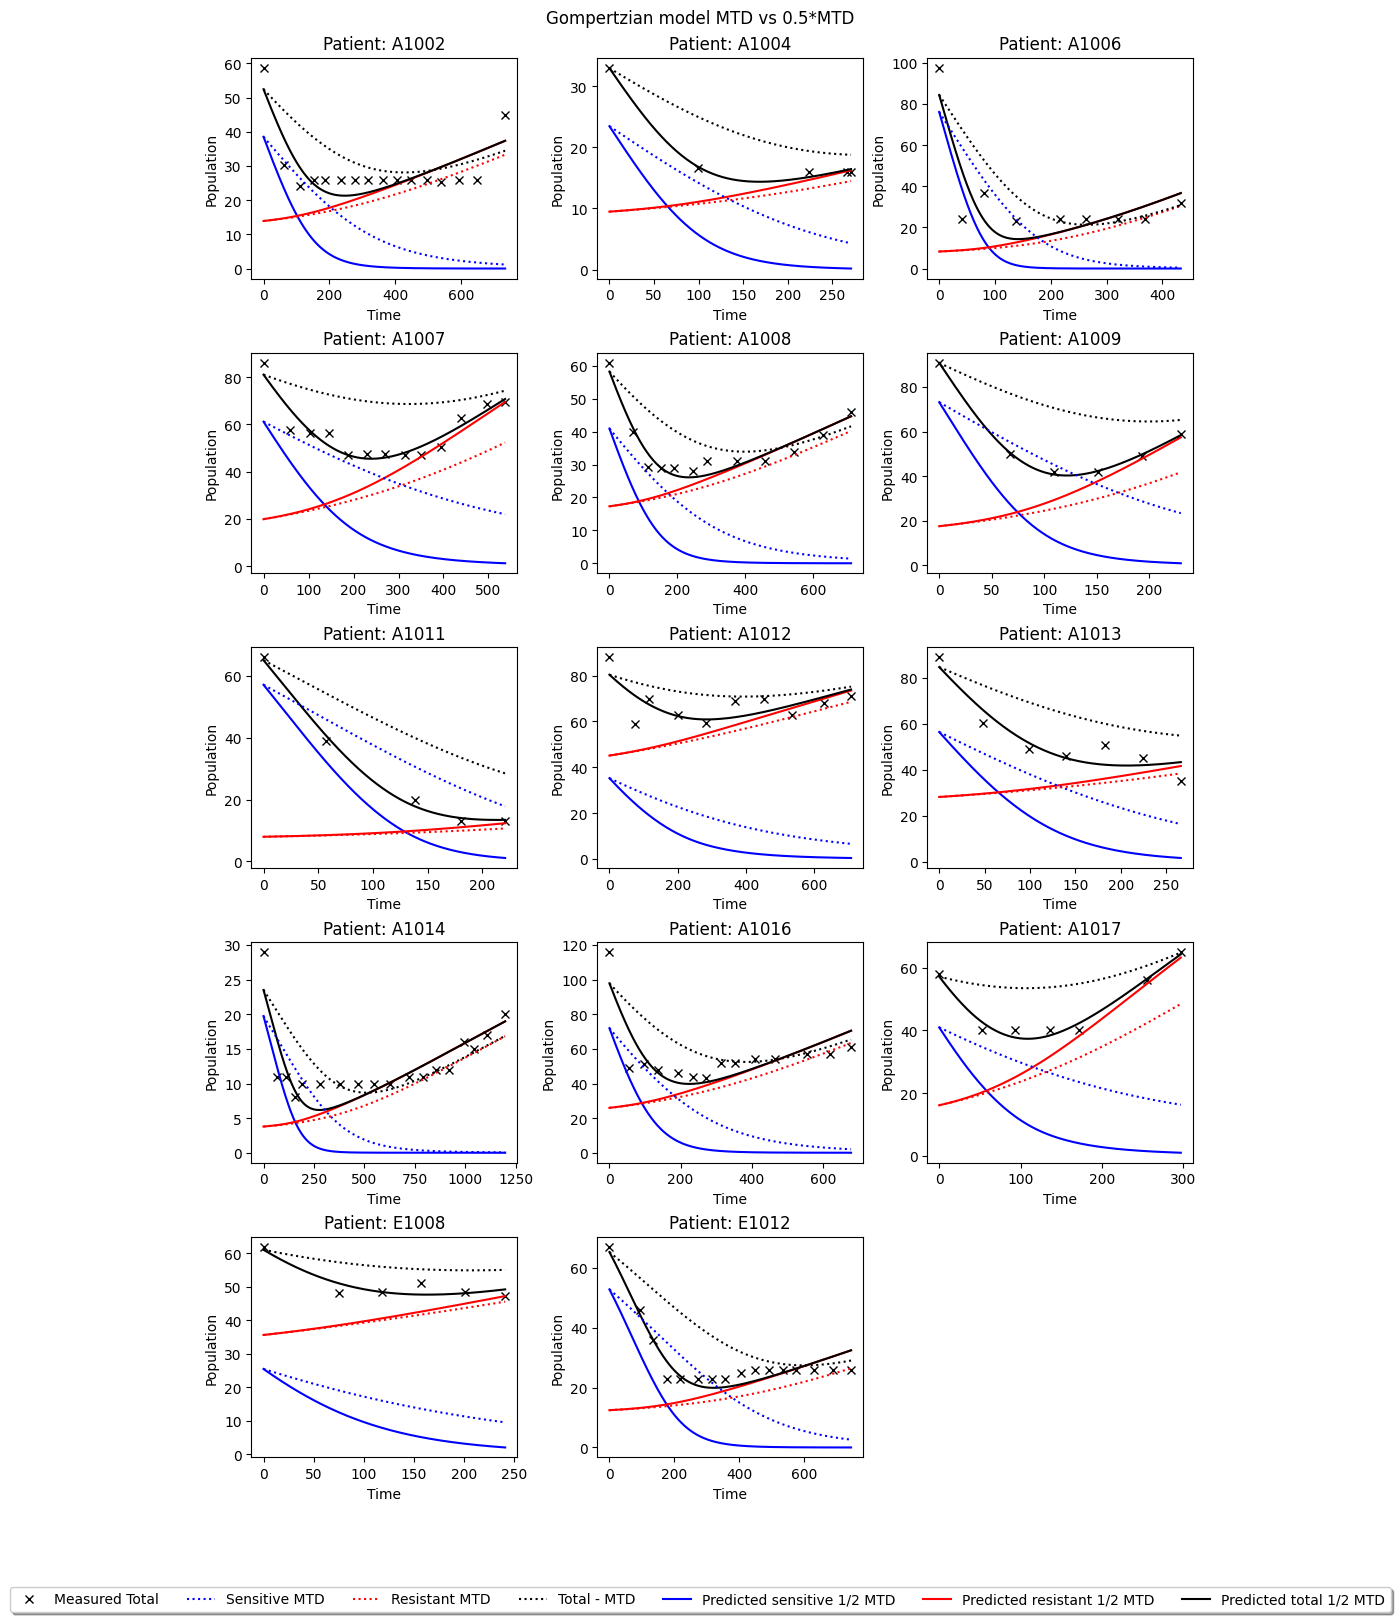

In [12]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 3
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 15), constrained_layout=True)

# fitting data for parameters with half medication
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ### optimal params original medication 
    optimal_params = master_dictionary[id]
    init_populations = optimal_params[3:-1]

    pred_data = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

    ### optimal params 1/2 medication
    optimal_params_half = master_dictionary_copy[id] # use parameters with 1/2 medication
    init_populations_half = optimal_params_half[3:-1]

    pred_data_half = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_half, dense_output=True, 
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    #plot data
    ax.plot(days, data, 'kx', label='Measured Total') 
    # plot with full medication
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive MTD') # plot logistic model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant MTD') 
    ax.plot(tspan, sum_pops, 'k-', label='Total MTD')

    # plot with half medication
    ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD') 
    ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD') 
    ax.plot(tspan, sum_pops_half, 'k:', label='Total 0.5*MTD')

    #set axis labels
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', linestyle=':',label='Sensitive MTD'),
                   Line2D([0], [0], color='r',linestyle=':', label='Resistant MTD'),
                   Line2D([0], [0], color='k', linestyle=':',label='Total - MTD'),

                   Line2D([0], [0], color='b',  label='Predicted sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r',  label='Predicted resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', label='Predicted total 1/2 MTD')]


fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model MTD vs 0.5*MTD')  
plt.show()

##### Extended predictions 1/2 MTD vs MTD

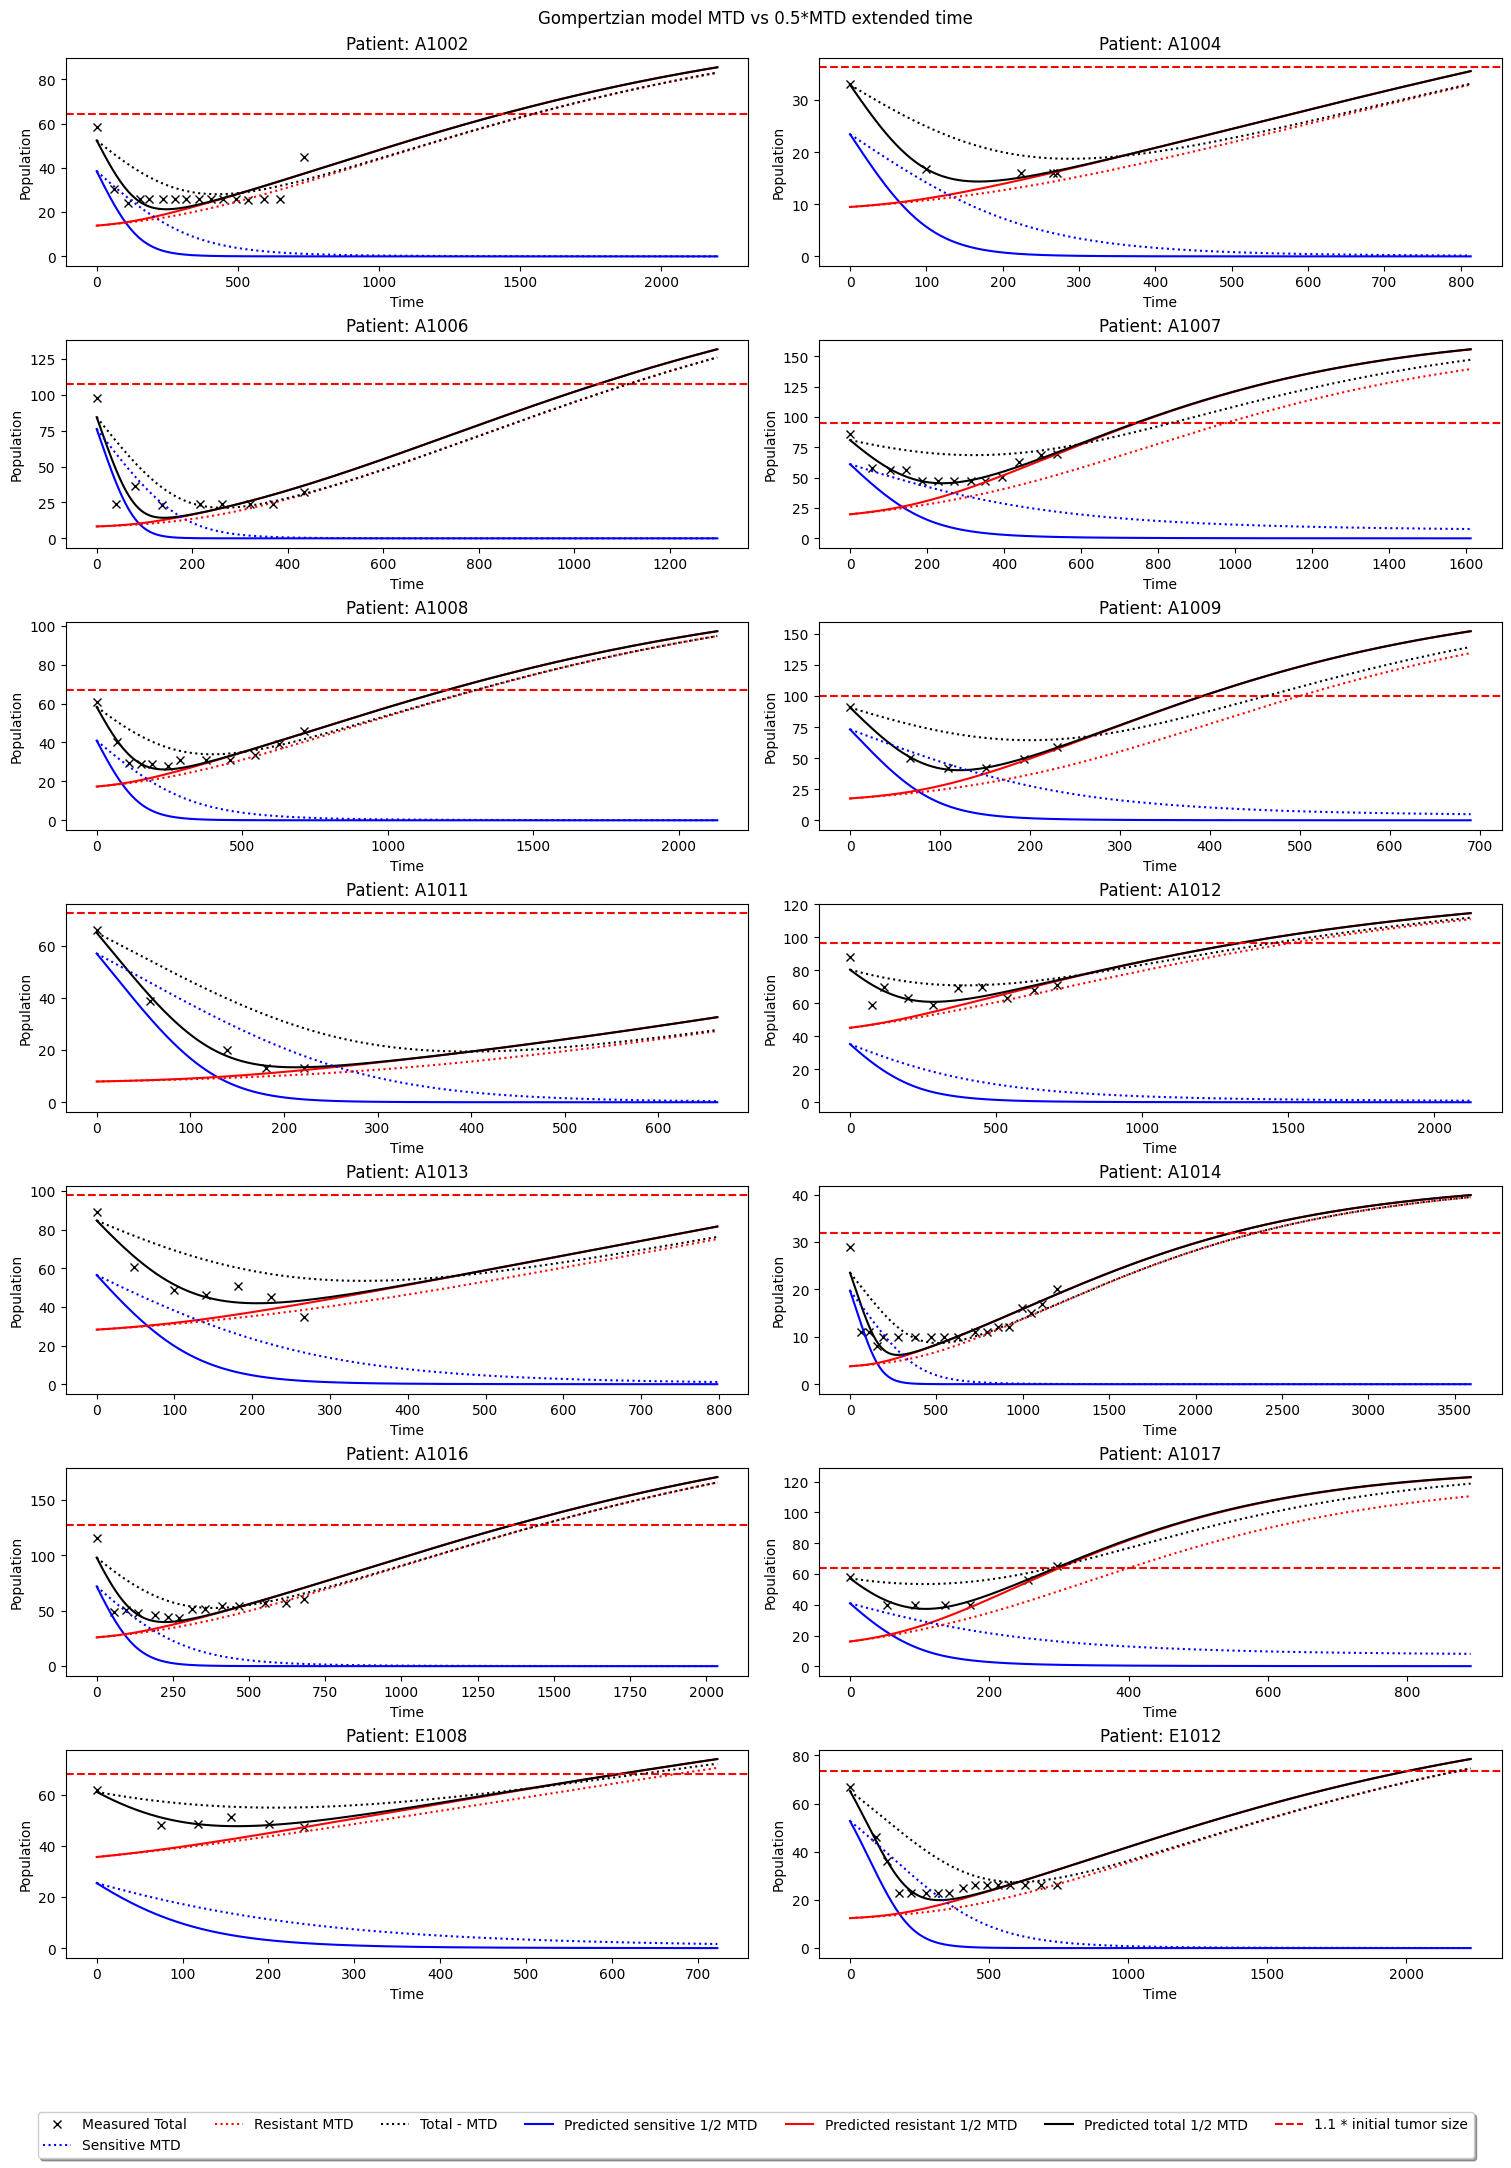

In [22]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

sim_time_factor=3

# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 20), constrained_layout=True)

# fitting data for parameters with half medication
for index, id in enumerate(unique_IDs, start=0):
    
    days = df.days[df.ID == id].tolist()
    data = df.sum_tumor_lengths[df.ID == id].tolist()
    tspan = np.linspace(0, sim_time_factor*days[-1], 500)

    ### optimal params original medication 
    optimal_params = master_dictionary[id]
    init_populations = optimal_params[3:-1]

    pred_data = solve_ivp(system_ode_gompertizian, [0,sim_time_factor*days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data.sol(tspan), axis=0)

    ### optimal params 1/2 medication
    optimal_params_half = master_dictionary_copy[id] # use parameters with 1/2 medication
    init_populations_half = optimal_params_half[3:-1]

    pred_data_half = solve_ivp(system_ode_gompertizian, [0,sim_time_factor*days[-1]],
                            init_populations_half, dense_output=True,
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  

    ax.plot(days, data, 'kx', label='Measured Total') 
    # plot with full medication
    ax.plot(tspan, pred_data.sol(tspan)[0], 'b-', label='Sensitive MTD') # plot logistic model
    ax.plot(tspan, pred_data.sol(tspan)[1], 'r-', label='Resistant MTD') 
    ax.plot(tspan, sum_pops, 'k-', label='Total MTD')
    ax.axhline(y=1.1*data[0], color='r', linestyle='--') ### line to show progression


    # plot with half medication
    ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD') 
    ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD') 
    ax.plot(tspan, sum_pops_half, 'k:', label='Total 0.5*MTD')

    #set axis labels
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', linestyle=':',label='Sensitive MTD'),
                   Line2D([0], [0], color='r',linestyle=':', label='Resistant MTD'),
                   Line2D([0], [0], color='k', linestyle=':',label='Total - MTD'),

                   Line2D([0], [0], color='b',  label='Predicted sensitive 1/2 MTD'),
                   Line2D([0], [0], color='r',  label='Predicted resistant 1/2 MTD'),
                   Line2D([0], [0], color='k', label='Predicted total 1/2 MTD'),
                   Line2D([0], [0], color='r', linestyle='--', label='1.1 * initial tumor size')]

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model MTD vs 0.5*MTD extended time')  
plt.show()

#### repeating with volume 

In [25]:
# Gompertizian population model
def system_ode_gompertizian(days,populations, params):
    Spop = populations[0]
    Rpop = populations[1]
    r = params[0] #growth rate
    kmax = params[1] #carrying capacity
    lam = params[2] #sensitivity to medication
    m=1
    epsilon = 1e-9
    log_arg = kmax/(Spop + Rpop + epsilon) # stop division by 0

    if log_arg <= 0:
        return [1e30, 1e30] # return large error if log is 0 or negative

    dSpop_dt = r *np.log(kmax/(Spop+Rpop + epsilon)) * (1-lam*m)*Spop 
    dRpop_dt = r * np.log(kmax/(Spop+Rpop + epsilon))*Rpop
    return [dSpop_dt, dRpop_dt]

# Gompertizian cost function - to avoid overflow
def cost_func_gompertizian(params, days, data):
    initial_populations = params[3:]
    tspan = [days[0], days[-1]]
    epsilon = 1e-9
    
    pred_data = solve_ivp(system_ode_gompertizian, tspan, initial_populations, 
                             t_eval = np.ravel(days),  args = tuple([params[:3]]))
    
    if pred_data.y.shape[1] == np.ravel(days).shape[0]:
        spop = pred_data.y[0]
        rpop = pred_data.y[1]
        sum_pops = spop + rpop

        # Check for overflow
        if np.any(np.abs(sum_pops) > 1e100):
            return 1e100  # Return a large cost

        sumsq_error = np.sum((sum_pops-data)**2)
        msq_error = sumsq_error/len(data)
        rmse = np.sqrt(msq_error)
    else: 
        msq_error = 1e30
        rmse = 1e30

    return msq_error


In [52]:
unique_IDs = df.ID.unique()
master_dictionary = {} # dictionary to store the optimized parameters for each patient 
scale_factor = 1 # to stop overflow errors, reduce size of measurements (e.g. 1000 = mm^3 --> cm^3)

# Find optimal parameters for each patient
for id in unique_IDs:

    days = df.days[df.ID == id].tolist()
    data = (df.Sum_tumor_volume[df.ID == id]/scale_factor).tolist()
    max_value = max(data[0]/scale_factor, data[-1]/scale_factor)

    print("Working on patient:", id, " Number of data points:", len(days))
    bounds = [(2e-3, 2e-1),                 # r
              (1.1*max_value, 2*max_value), # Kmax
              (1, 50),                     #lambda effect of medication
              (0.9*data[0], data[0]-1e-3), 
              (1e-3,0.1*data[0]
               )]

    # Use differential_evolution to perform a random search
    opt_result = differential_evolution(cost_func_gompertizian, bounds, args=(days, data))
    # store the optimal parameters and the cost function value (last entry in list)
    master_dictionary[id] = opt_result.x.tolist() + [opt_result.fun]

Working on patient: A1002  Number of data points: 16
Working on patient: A1004  Number of data points: 5
Working on patient: A1006  Number of data points: 9
Working on patient: A1007  Number of data points: 13
Working on patient: A1008  Number of data points: 12
Working on patient: A1009  Number of data points: 6
Working on patient: A1011  Number of data points: 5
Working on patient: A1012  Number of data points: 10
Working on patient: A1013  Number of data points: 7
Working on patient: A1014  Number of data points: 18
Working on patient: A1016  Number of data points: 14
Working on patient: A1017  Number of data points: 7
Working on patient: E1008  Number of data points: 6
Working on patient: E1012  Number of data points: 16


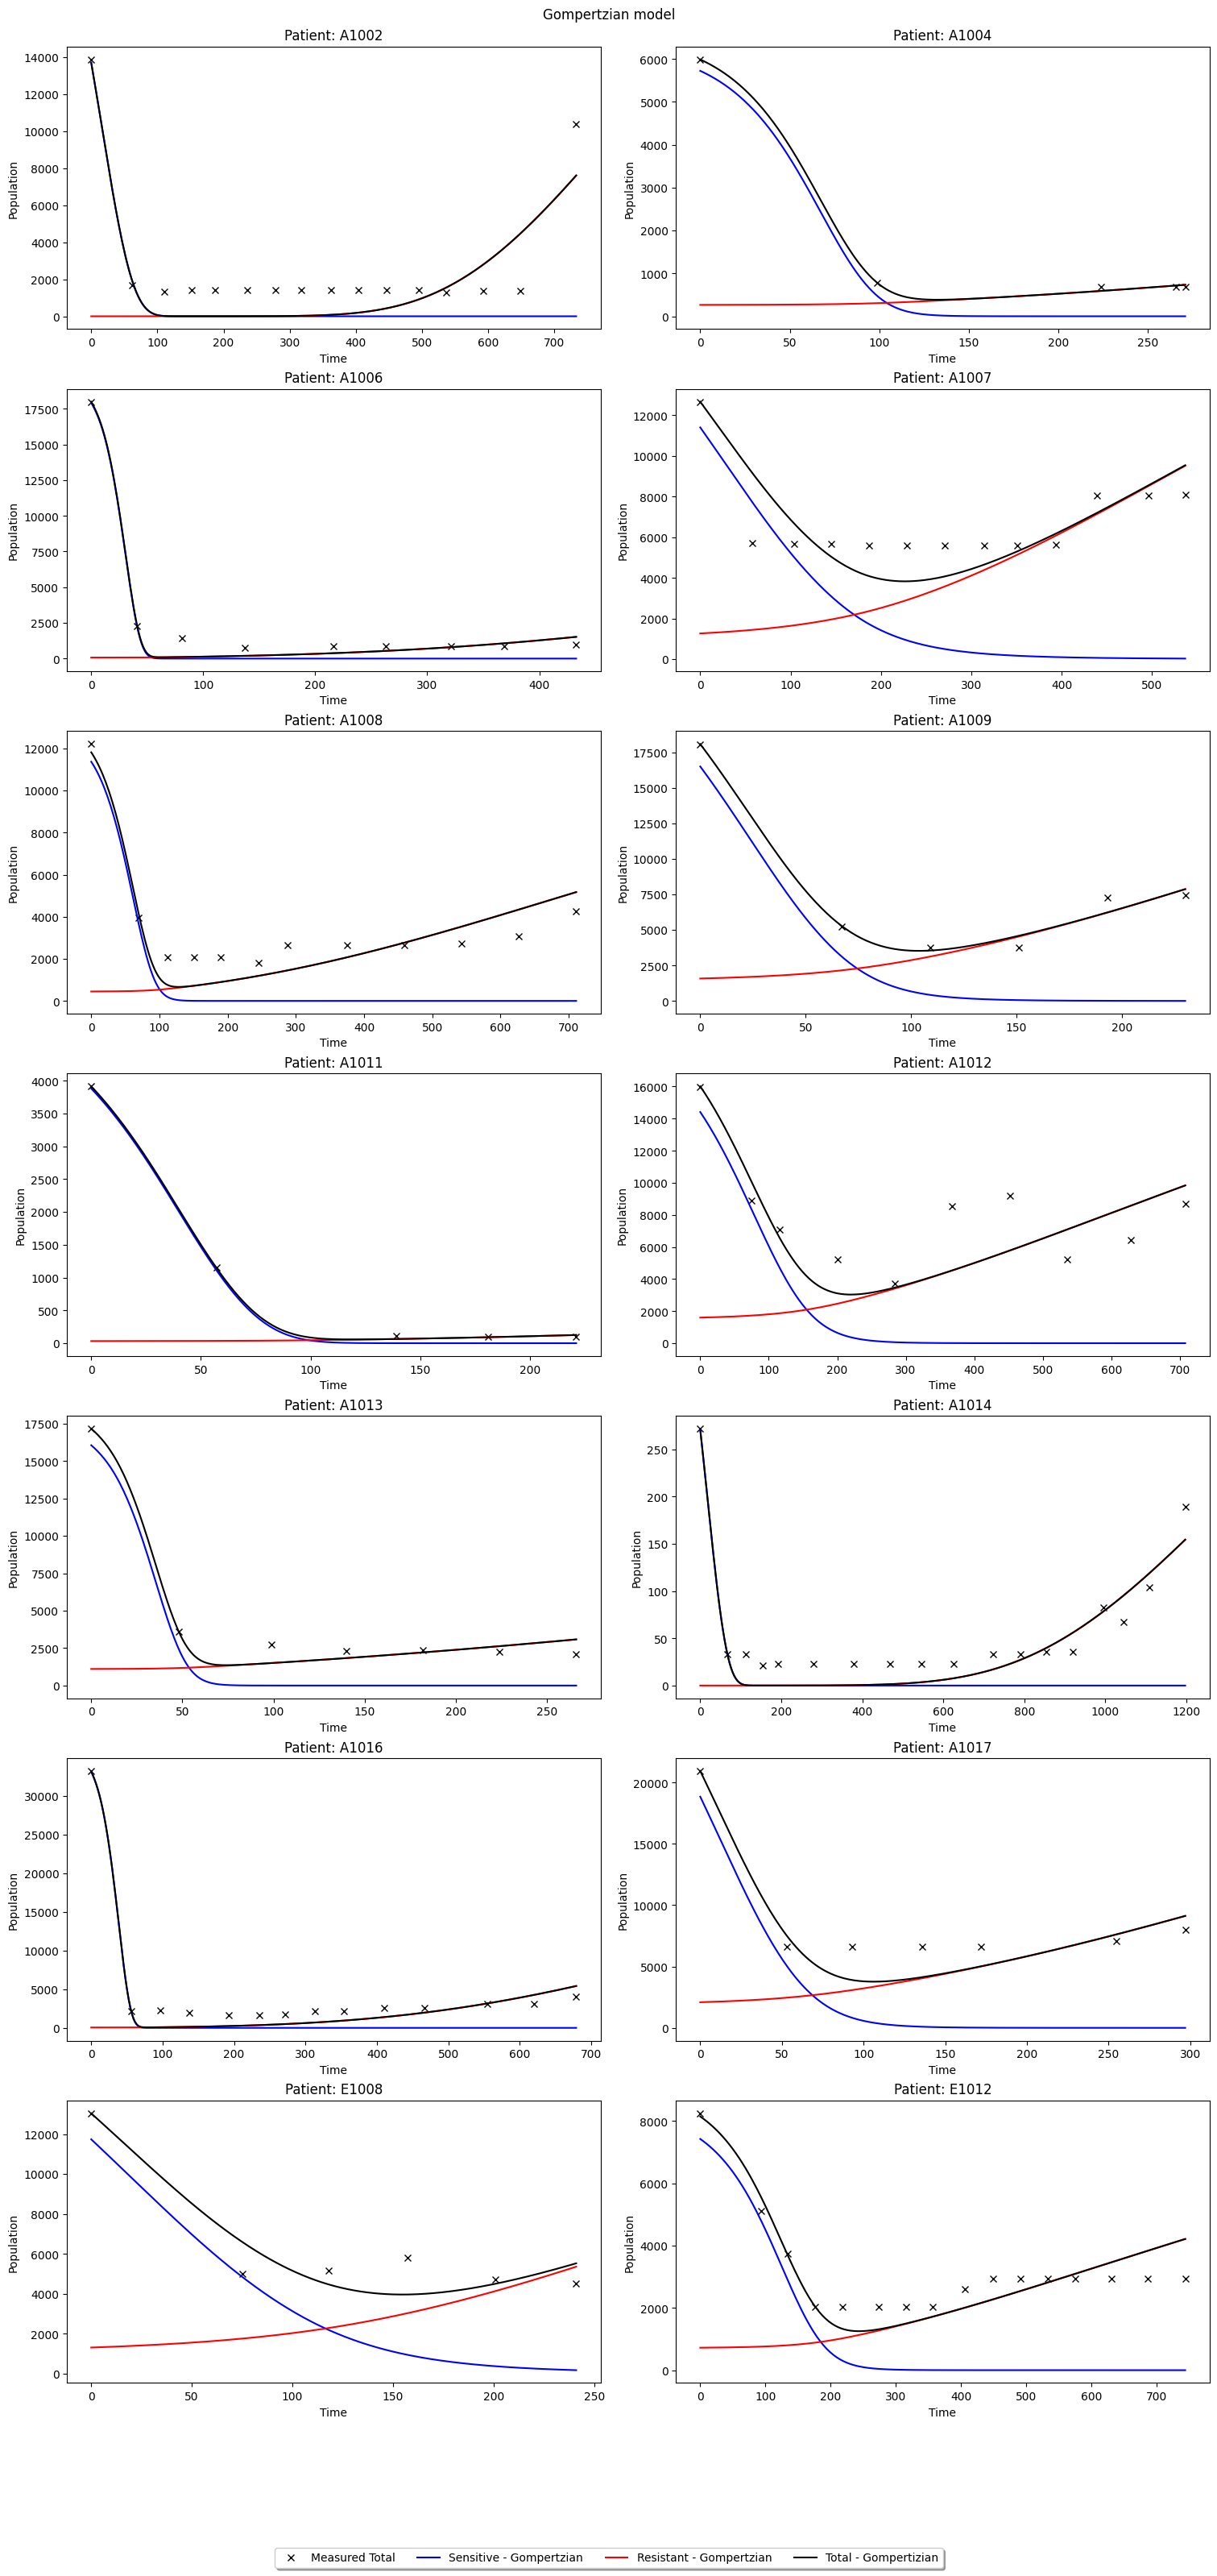

In [69]:
# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15,30), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_gom = master_dictionary[id]
    init_populations_gom = optimal_params_gom[3:-1]

    pred_data_gom = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_gom, dense_output=True,
                            args = tuple([optimal_params_gom[:3]]))
    sum_pops_gom = np.sum(pred_data_gom.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    ax.plot(tspan, pred_data_gom.sol(tspan)[0], 'b-', label='Sensitive - Gompertz ')
    ax.plot(tspan, pred_data_gom.sol(tspan)[1], 'r-', label='Resistant - Gompertz') 
    ax.plot(tspan, sum_pops_gom, 'k-', label='Total - Gompertz')
    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   Line2D([0], [0], color='b', label='Sensitive - Gompertzian'),
                   Line2D([0], [0], color='r', label='Resistant - Gompertzian'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Gompertizian'),]
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model')  
plt.show()

In [54]:
df_gomp = pd.DataFrame.from_dict(master_dictionary, orient='index', 
                                     columns=['r','Kmax','lamda','spop_0','rpop_0','mse'])
df_gomp

,r,Kmax,lamda,spop_0,rpop_0,mse
A1002,0.004085,27687.671151,6.270238,13690.136916,0.001000,2.220720e+06
A1004,0.002000,6590.419432,18.675682,5722.976807,265.231322,2.448106e+03
A1006,0.002000,19829.734354,39.045917,17917.111914,71.829487,3.014670e+05
A1007,0.002648,25332.737644,4.013522,11404.581992,1263.839343,1.935761e+06
A1008,0.002000,13445.639979,17.933553,11370.661211,447.537198,8.657303e+05
A1009,0.004343,30444.521753,6.366634,16499.353692,1579.132277,3.297549e+05
A1011,0.002000,5434.352931,14.845584,3880.416342,32.534561,7.273781e+02
A1012,0.002000,21791.716294,8.173873,14414.169338,1598.129261,4.319694e+06
A1013,0.002000,18878.584086,34.836611,16053.368123,1105.521942,4.135222e+05
A1014,0.002133,543.287122,10.731187,270.841978,0.001000,3.883509e+02


##### with 0.5 MTD

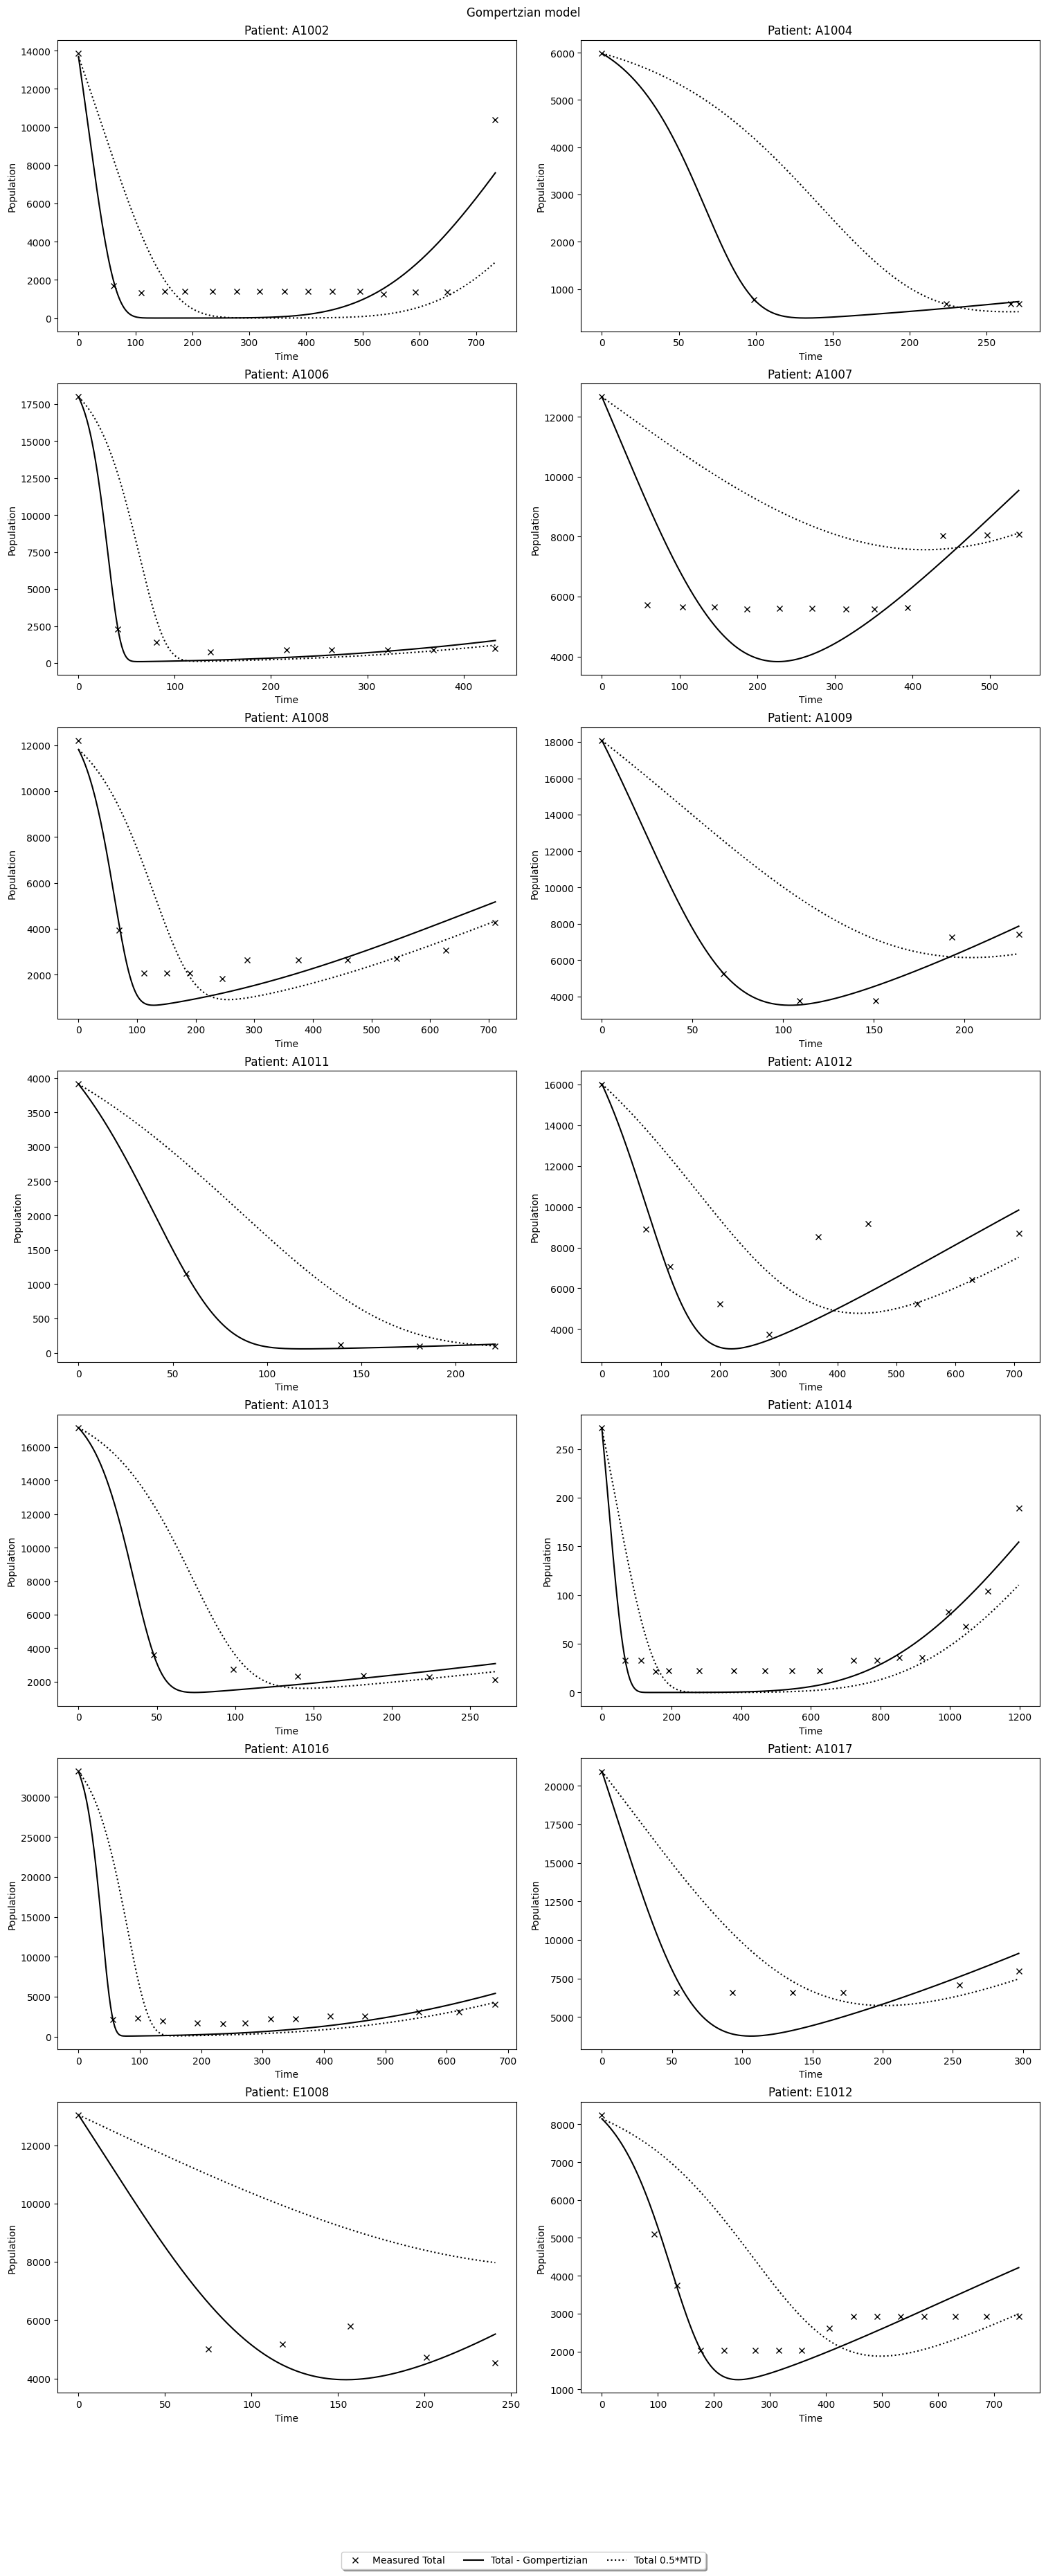

In [70]:
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 35), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    optimal_params_gom = master_dictionary[id]
    init_populations_gom = optimal_params_gom[3:-1]

    pred_data_gom = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_gom, dense_output=True,
                            args = tuple([optimal_params_gom[:3]]))
    sum_pops_gom = np.sum(pred_data_gom.sol(tspan), axis=0)

    # half dose
    optimal_params_half = master_dictionary_copy[id]
    init_populations_half = optimal_params_half[3:-1]

    pred_data_half = solve_ivp(system_ode_gompertizian, [0,days[-1]],
                            init_populations_half, dense_output=True,
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)

#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, days[-1], 300)

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    #ax.plot(tspan, pred_data_gom.sol(tspan)[0], 'b-', label='Sensitive - Gompertz ')
    #ax.plot(tspan, pred_data_gom.sol(tspan)[1], 'r-', label='Resistant - Gompertz') 
    ax.plot(tspan, sum_pops_gom, 'k-', label='Total - Gompertz')

    #ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD')
    #ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD')
    ax.plot(tspan, np.sum(pred_data_half.sol(tspan), axis=0), 'k:', label='Total 0.5*MTD')

    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   #Line2D([0], [0], color='b', label='Sensitive - Gompertzian'),
                   #Line2D([0], [0], color='r', label='Resistant - Gompertzian'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Gompertizian'),
                   #Line2D([0], [0], color='b', linestyle=':',label='Sensitive 0.5*MTD'),
                   #Line2D([0], [0], color='r', linestyle=':',label='Resistant 0.5*MTD'),
                   Line2D([0], [0], color='k', linestyle= ':' ,label='Total 0.5*MTD'),
                   ]
                    
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model')  
plt.show()

##### Extending time

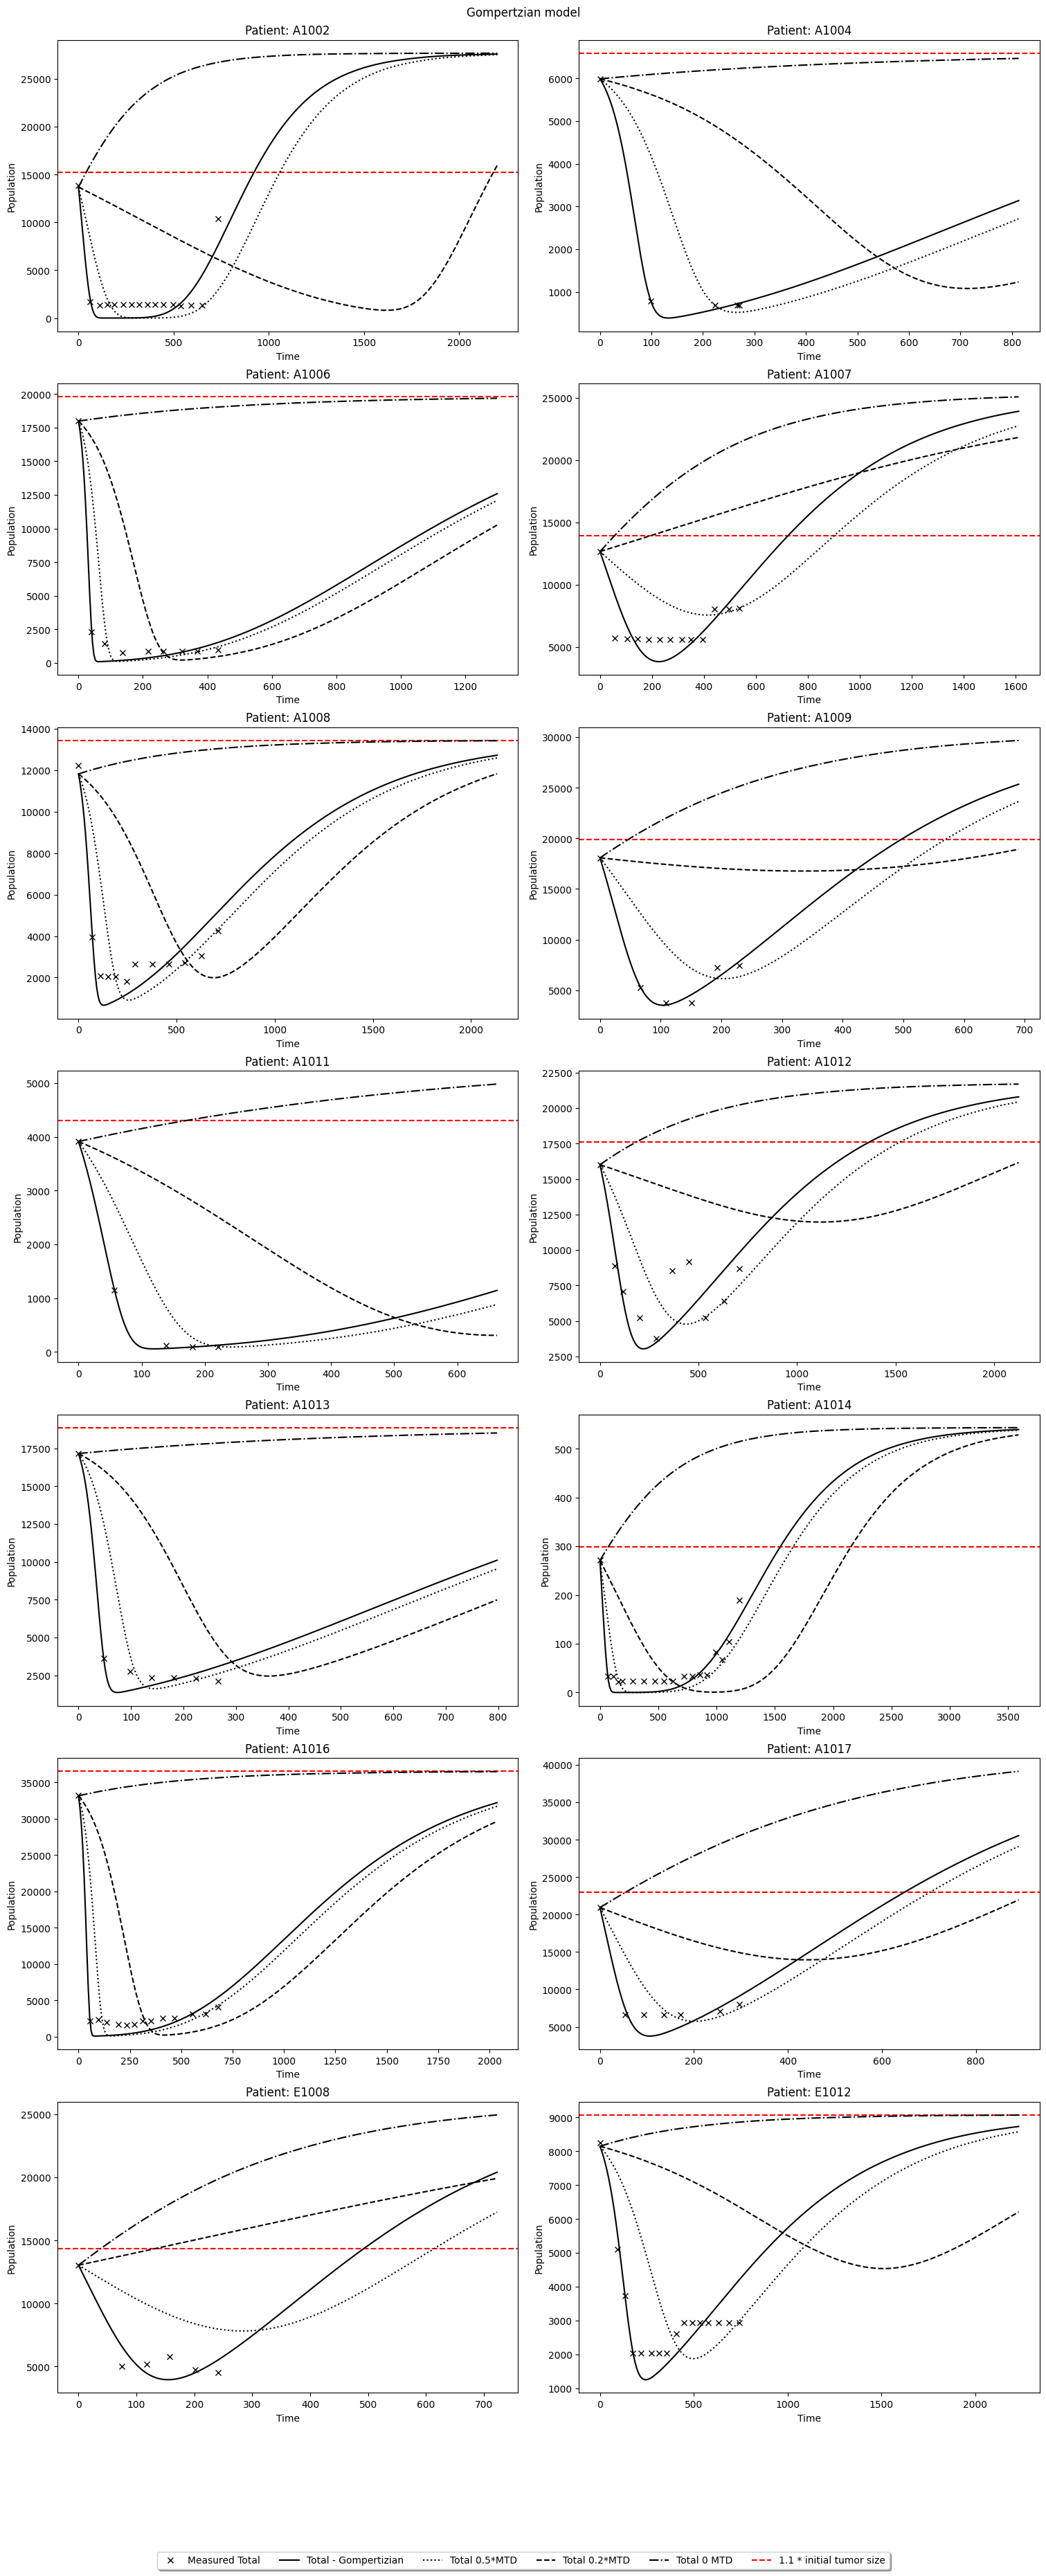

In [74]:
progression_list = []
progression_half_list = []
progression_02_list = []
progression_list_0 = []
comp_release_list = []
comp_release_half_list = []
comp_release_02_list = []
comp_release_list_0 = []

sim_time_factor = 3

# Store changed medication parameters
master_dictionary_copy = copy.deepcopy(master_dictionary) # deep to create a copy that can be changed
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5

master_dictionary_copy2 = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy2:
    master_dictionary_copy2[key][2] *= 0.2 # simulate dose of 0.2 MTD

master_dictionary_copy0 = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy0:
    master_dictionary_copy0[key][2] *= 0 # simulate dose of 0

# setting up subplots   
n = len(unique_IDs)
ncols = 2
nrows = np.ceil(n / ncols).astype(int)
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 35), constrained_layout=True)

# fitting data 
for index, id in enumerate(unique_IDs, start=0):
    #print("Patient:", id, " Optimal parameters: ", master_dictionary[id])
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, sim_time_factor*days[-1], 300)

# MTD
    optimal_params_gom = master_dictionary[id]
    init_populations_gom = optimal_params_gom[3:-1]

    pred_data_gom = solve_ivp(system_ode_gompertizian, [0,sim_time_factor*days[-1]],
                            init_populations_gom, dense_output=True,
                            args = tuple([optimal_params_gom[:3]]))
    sum_pops_gom = np.sum(pred_data_gom.sol(tspan), axis=0)

    # half dose
    optimal_params_half = master_dictionary_copy[id]
    init_populations_half = optimal_params_half[3:-1]

    pred_data_half = solve_ivp(system_ode_gompertizian, [0,sim_time_factor*days[-1]],
                            init_populations_half, dense_output=True,
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)

    # 0.2 dose
    optimal_params_02 = master_dictionary_copy2[id]
    init_populations_02 = optimal_params_02[3:-1]

    pred_data_02 = solve_ivp(system_ode_gompertizian, [0,sim_time_factor*days[-1]],
                            init_populations_02, dense_output=True,
                            args = tuple([optimal_params_02[:3]]))
    sum_pops_02 = np.sum(pred_data_02.sol(tspan), axis=0)

    # 0 dose
    optimal_params_0 = master_dictionary_copy0[id]
    init_populations_0 = optimal_params_0[3:-1]

    pred_data_0 = solve_ivp(system_ode_gompertizian, [0,sim_time_factor*days[-1]],
                            init_populations_0, dense_output=True,
                            args = tuple([optimal_params_0[:3]]))

    sum_pops_0 = np.sum(pred_data_0.sol(tspan), axis=0)

 # Find progression for Gompertzian MTD
    progression_mtd = np.argmin(np.abs(sum_pops_gom - 1.1*data[0]))
    x_value_progression = tspan[progression_mtd]
    progression_list.append(x_value_progression)

# Find progression for Gompertzian 1/2 MTD
    progression_half = np.argmin(np.abs(sum_pops_half - 1.1*data[0]))
    x_value_progression_half = tspan[progression_half]
    progression_half_list.append(x_value_progression_half)

# Find progression for Gompertzian 0.2 MTD
    progression_02 = np.argmin(np.abs(sum_pops_02 - 1.1*data[0]))
    x_value_progression_02 = tspan[progression_02]
    progression_02_list.append(x_value_progression_02)

# Find progression for Gompertzian 0 MTD
    progression_0 = np.argmin(np.abs(sum_pops_0 - 1.1*data[0]))
    x_value_progression_0 = tspan[progression_0]
    progression_list_0.append(x_value_progression_0)


#plotting 
    ax = axs.flatten()[(index)%len(unique_IDs)]  
    ax.axhline(y=1.1*data[0], color='r', linestyle='--') ### line to show progression

    ax.plot(days, data, 'kx', label='Measured Total') # plot data points
    #ax.plot(tspan, pred_data_gom.sol(tspan)[0], 'b-', label='Sensitive - Gompertz ')
    #ax.plot(tspan, pred_data_gom.sol(tspan)[1], 'r-', label='Resistant - Gompertz') 
    ax.plot(tspan, sum_pops_gom, 'k-', label='Total - Gompertz')

    #ax.plot(tspan, pred_data_half.sol(tspan)[0], 'b:', label='Sensitive 0.5*MTD')
    #ax.plot(tspan, pred_data_half.sol(tspan)[1], 'r:', label='Resistant 0.5*MTD')
    ax.plot(tspan, np.sum(pred_data_half.sol(tspan), axis=0), 'k:', label='Total 0.5*MTD')

    #ax.plot(tspan, pred_data_02.sol(tspan)[0], 'b--', label='Sensitive 0.2*MTD')
    #ax.plot(tspan, pred_data_02.sol(tspan)[1], 'r--', label='Resistant 0.2*MTD')
    ax.plot(tspan, np.sum(pred_data_02.sol(tspan), axis=0), 'k--', label='Total 0.2*MTD')

    #ax.plot(tspan, pred_data_0.sol(tspan)[0], 'b-.', label='Sensitive 0 MTD')
    #ax.plot(tspan, pred_data_0.sol(tspan)[1], 'r-.', label='Resistant 0 MTD')
    ax.plot(tspan, np.sum(pred_data_0.sol(tspan), axis=0), 'k-.', label='Total 0 MTD')

    ax.set_xlabel('Time')
    ax.set_ylabel('Population')
    ax.set_title(f'Patient: {id}') 

for i in range(index+1, nrows*ncols):
    axs.flatten()[i].axis('off') #hide empty subplots

legend_elements = [Line2D([0], [0], marker='x', color='k', label='Measured Total', linestyle='None'),
                   #Line2D([0], [0], color='b', label='Sensitive - Gompertzian'),
                   #Line2D([0], [0], color='r', label='Resistant - Gompertzian'),
                   Line2D([0], [0], color='k', linestyle= '-' ,label='Total - Gompertizian'),
                   #Line2D([0], [0], color='b', linestyle=':',label='Sensitive 0.5*MTD'),
                   #Line2D([0], [0], color='r', linestyle=':',label='Resistant 0.5*MTD'),
                   Line2D([0], [0], color='k', linestyle= ':' ,label='Total 0.5*MTD'),
                   #Line2D([0], [0], color='b', linestyle='--',label='Sensitive 0.2*MTD'),
                   #Line2D([0], [0], color='r', linestyle='--',label='Resistant 0.2*MTD'),
                   Line2D([0], [0], color='k', linestyle= '--' ,label='Total 0.2*MTD'),
                   #Line2D([0], [0], color='b', linestyle='-.',label='Sensitive 0 MTD'),
                   #Line2D([0], [0], color='r', linestyle='-.',label='Resistant 0 MTD'),
                   Line2D([0], [0], color='k', linestyle= '-.' ,label='Total 0 MTD'),
                   Line2D([0], [0], color='r', linestyle='--', label='1.1 * initial tumor size')
                        ]
                    
          
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), 
fancybox=True, shadow=True, ncol=7)
fig.suptitle('Gompertzian model')  
plt.show()

##### survival plots

In [75]:
# lists to store progression and competitive release times
progression_list = []
progression_half_list = []
progression_02_list = []
progression_list_0 = []
comp_release_list = []
comp_release_half_list = []
comp_release_02_list = []
comp_release_list_0 = []

sim_time_factor = 10 ### change this to extend time

# Store changed medication parameters
master_dictionary_copy = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy:
    master_dictionary_copy[key][2] *= 0.5 # simulate dose of 0.5 MTD

master_dictionary_copy2 = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy2:
    master_dictionary_copy2[key][2] *= 0.2 # simulate dose of 0.2 MTD

master_dictionary_copy0 = copy.deepcopy(master_dictionary) 
for key in master_dictionary_copy0:
    master_dictionary_copy0[key][2] *= 0 # simulate dose of 0


for index, id in enumerate(unique_IDs, start=0):
    days = df.days[df.ID == id].tolist()
    data = df.Sum_tumor_volume[df.ID == id].tolist()
    tspan = np.linspace(0, sim_time_factor*days[-1], 1000)

### optimal params original medication 
    optimal_params = master_dictionary[id]
    init_populations = [optimal_params[3],data[0]-optimal_params[3]]
    pred_data_log = solve_ivp(system_ode_gompertizian, [0,sim_time_factor*days[-1]],
                            init_populations, dense_output=True,
                            args = tuple([optimal_params[:3]]))
    sum_pops = np.sum(pred_data_log.sol(tspan), axis=0)

### optimal params 1/2 medication
    optimal_params_half = master_dictionary_copy[id] 
    init_populations_half = [optimal_params_half[3],data[0]-optimal_params_half[3]]

    pred_data_log_half = solve_ivp(system_ode_gompertizian, [0, sim_time_factor*days[-1]],
                            init_populations_half, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_half[:3]]))
    sum_pops_half = np.sum(pred_data_half.sol(tspan), axis=0)

### optimal params 0.2 medication
    optimal_params_02 = master_dictionary_copy2[id] 
    init_populations_02 = [optimal_params_02[3],data[0]-optimal_params_02[3]]

    pred_data_02 = solve_ivp(system_ode_gompertizian, [0, sim_time_factor*days[-1]],
                            init_populations_02, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_02[:3]]))
    sum_pops_02 = np.sum(pred_data_02.sol(tspan),    axis=0)

### optimal params 0 medication
    optimal_params_0 = master_dictionary_copy0[id]
    init_populations_0 = [optimal_params_0[3],data[0]-optimal_params_0[3]]

    pred_data_0 = solve_ivp(system_ode_gompertizian, [0, sim_time_factor*days[-1]],
                            init_populations_0, dense_output=True, max_step = 1,
                            args = tuple([optimal_params_0[:3]]))
    sum_pops_0 = np.sum(pred_data_0.sol(tspan), axis=0)                        

# Find progression for logistic MTD
    progression_mtd = np.argmin(np.abs(sum_pops - 1.1*data[0]))
    x_value_progression = tspan[progression_mtd]
    progression_list.append(x_value_progression)

# Find progression for logistic half MTD
    progression_half_mtd = np.argmin(np.abs(sum_pops_half - 1.1*data[0]))
    x_value_progression_half = tspan[progression_half_mtd]
    progression_half_list.append(x_value_progression_half)

# Find progression for logistic 0.2 MTD
    progression_02_mtd = np.argmin(np.abs(sum_pops_02 - 1.1*data[0]))
    x_value_progression_02 = tspan[progression_02_mtd]
    progression_02_list.append(x_value_progression_02)

# Find progression for logistic 0 MTD
    progression_0_mtd = np.argmin(np.abs(sum_pops_0 - 1.1*data[0]))
    x_value_progression_0 = tspan[progression_0_mtd]
    progression_list_0.append(x_value_progression_0)

# find time to competitive release MTD
    comp_rel_mtd = np.argmin(np.abs(pred_data.sol(tspan)[0]-pred_data.sol(tspan)[1]))
    x_val_cr_mtd = tspan[comp_rel_mtd]
    comp_release_list.append(x_val_cr_mtd)

# find time to competitive release half MTD
    comp_rel_half = np.argmin(np.abs(pred_data_half.sol(tspan)[0]-pred_data_half.sol(tspan)[1]))
    x_val_cr_half = tspan[comp_rel_half]
    comp_release_half_list.append(x_val_cr_half)

# find time to competitive release 0.2 MTD
    comp_rel_02 = np.argmin(np.abs(pred_data_02.sol(tspan)[0]-pred_data_02.sol(tspan)[1]))
    x_val_cr_02 = tspan[comp_rel_02]
    comp_release_02_list.append(x_val_cr_02)

# find time to competitive release 0 MTD
    comp_rel_0 = np.argmin(np.abs(pred_data_0.sol(tspan)[0]-pred_data_0.sol(tspan)[1]))
    x_val_cr_0 = tspan[comp_rel_0]
    comp_release_list_0.append(x_val_cr_0)
   
# Combine lists into a DataFrame
df_all_progressions = pd.DataFrame({
    'id': unique_IDs,
    'progression': progression_list,
    'progression half MTD': progression_half_list,
    'progression 0.2 MTD' : progression_02_list,
    'progression 0 ' : progression_list_0,
    'competitive release': comp_release_list,
    'competitive release half MTD': comp_release_half_list,
    'competitive release 0.2 MTD' : comp_release_02_list,
    'competitive release 0 ' : comp_release_list_0
})

# adding event columns 
df_all_progressions['progression_event'] = df_all_progressions['progression'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['progression_event_half'] = df_all_progressions['progression half MTD'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['progression_event_02'] = df_all_progressions['progression 0.2 MTD'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['progression_event_0'] = df_all_progressions['progression 0 '].apply(lambda x: 0 if x == 0 else 1)

df_all_progressions['cr_event'] = df_all_progressions['competitive release'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['cr_event_half'] = df_all_progressions['competitive release half MTD'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['cr_event_02_MTD'] = df_all_progressions['competitive release 0.2 MTD'].apply(lambda x: 0 if x == 0 else 1)
df_all_progressions['cr_event_0'] = df_all_progressions['competitive release 0 '].apply(lambda x: 0 if x == 0 else 1)

# Print the DataFrame
df_all_progressions

,id,progression,progression half MTD,progression 0.2 MTD,progression 0,competitive release,competitive release half MTD,competitive release 0.2 MTD,competitive release 0,progression_event,progression_event_half,progression_event_02,progression_event_0,cr_event,cr_event_half,cr_event_02_MTD,cr_event_0
0,A1002,579.649650,4666.546547,1100.600601,36.686687,183.433433,403.553554,902.492492,0.0,1,1,1,1,1,1,1,0
1,A1004,2710.000000,151.911912,2710.000000,2710.000000,184.464464,406.906907,640.200200,0.0,1,1,1,1,1,1,1,0
2,A1006,4026.596597,4330.000000,4208.638639,1954.784785,186.376376,407.427427,290.400400,0.0,1,1,1,1,1,1,1,0
3,A1007,725.675676,4665.825826,193.513514,53.753754,182.762763,403.153153,5370.000000,0.0,1,1,1,1,1,1,1,0
4,A1008,3999.819820,4668.828829,4490.900901,2249.009009,185.045045,405.675676,661.891892,0.0,1,1,1,1,1,1,1,0
5,A1009,497.297297,2300.000000,771.271271,46.046046,184.184184,405.205205,771.271271,0.0,1,1,1,1,1,1,1,0
6,A1011,1614.914915,278.738739,1997.627628,170.340340,185.825826,404.834835,623.843844,0.0,1,1,1,1,1,1,1,0
7,A1012,1367.807808,4670.390390,2388.348348,184.264264,184.264264,6576.816817,1353.633634,0.0,1,1,1,1,1,1,1,0
8,A1013,2660.000000,2660.000000,2660.000000,2481.601602,183.723724,404.724725,298.218218,0.0,1,1,1,1,1,1,1,0
9,A1014,1174.234234,6566.126126,1581.621622,71.891892,179.729730,6578.108108,706.936937,0.0,1,1,1,1,1,1,1,0


median time to progression MTD: 1614.914914914915
median time to progression 1/2 MTD:  4330.0


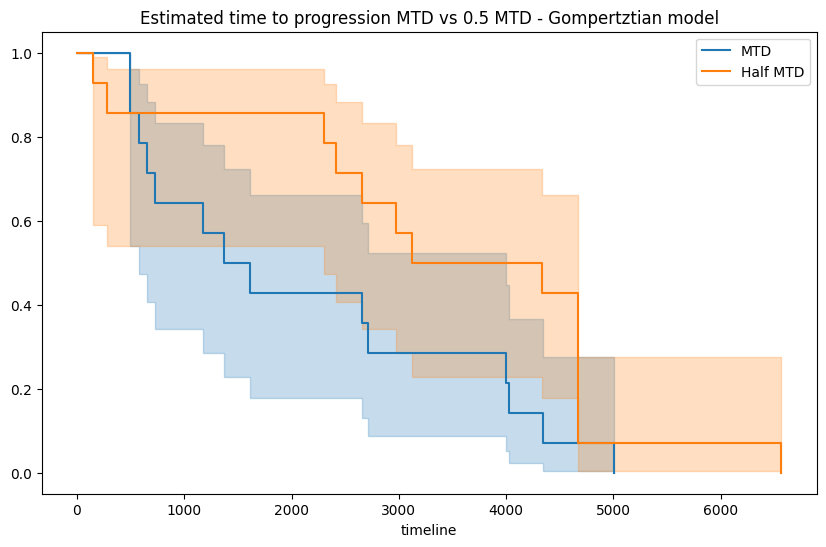

In [78]:
### survival plots for progression at 1.1*first data point 
Event1 = df_all_progressions["progression_event"]
Event2 = df_all_progressions["progression_event_half"]
Event3 = df_all_progressions["progression_event_02"]
Event4 = df_all_progressions["progression_event_0"]

kmf = KaplanMeierFitter()
# Set the figure size
plt.figure(figsize=(10, 6)) 

# plot for MTD progression
kmf.fit(df_all_progressions["progression"],Event1, label='MTD')
ax = kmf.plot_survival_function()
print("median time to progression MTD:", kmf.median_survival_time_)

# plot for 1/2 MTD progression
kmf.fit(df_all_progressions["progression half MTD"], Event2, label='Half MTD')
ax = kmf.plot_survival_function(ax=ax) 
ax.set_title("Estimated time to progression MTD vs 0.5 MTD - Gompertztian model")
print("median time to progression 1/2 MTD: ",kmf.median_survival_time_)

# plot for 0.2 MTD progression
#kmf.fit(df_all_progressions["progression 0.2 MTD"], Event3, label='0.2 MTD')
#ax = kmf.plot_survival_function(ax=ax)
#print("median time to progression 0.2 MTD: ",kmf.median_survival_time_)


median time to competitive release MTD: 184.32432432432432
median time to competitive release 1/2 dose:  405.6756756756757
median time to competitive release 0.2 dose:  706.936936936937


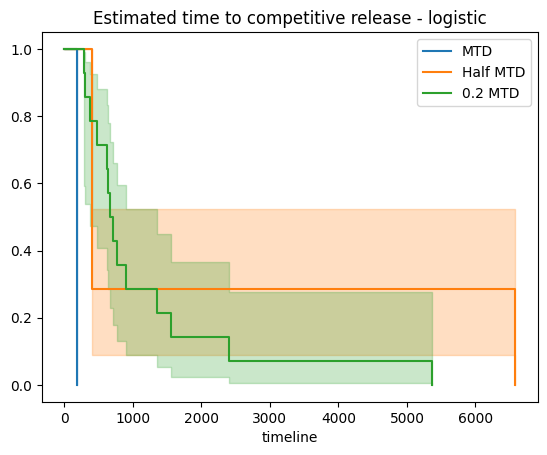

In [79]:
### survival plots for time to competitive release 
Event1 = df_all_progressions["cr_event"]
Event2 = df_all_progressions["cr_event_half"]
Event3 = df_all_progressions["cr_event_02_MTD"]

kmf = KaplanMeierFitter()

# plot for MTD progression
kmf.fit(df_all_progressions["competitive release"],Event1, label='MTD')
ax = kmf.plot_survival_function()
print("median time to competitive release MTD:", kmf.median_survival_time_)

# plot for 1/2 MTD progression
kmf.fit(df_all_progressions["competitive release half MTD"], Event2, label='Half MTD')
ax = kmf.plot_survival_function(ax=ax)
print("median time to competitive release 1/2 dose: ",kmf.median_survival_time_)

# plot for 0.2 MTD progression
kmf.fit(df_all_progressions["competitive release 0.2 MTD"], Event3, label='0.2 MTD')
ax = kmf.plot_survival_function(ax=ax)
ax.set_title('Estimated time to competitive release - logistic')

print("median time to competitive release 0.2 dose: ",kmf.median_survival_time_)

